# Haal-e-Dil Framework Stage 1 - Abnormal Vitals Detection

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Reading the dataset

In [2]:
df = pd.read_csv('vitals_data.csv')
df.head()

,respiratory_rate,blood_oxygen,blood_sugar,systolic_bp,diastolic_bp,heart_rate,class
0,16.264905,96.868933,78.848423,91.901717,81.837244,80.759321,0.0
1,13.941728,111.422624,80.321324,129.421813,68.489075,72.711591,1.0
2,15.680826,90.336757,85.815357,98.538505,81.632847,63.169450,1.0
3,19.892181,103.726693,90.686478,125.477558,75.219932,77.023003,1.0
4,9.612191,89.502531,85.021314,125.834351,65.319267,65.950300,1.0


## Data Understanding

Dataset size

In [3]:
df.shape

(50000, 7)

Dataset column types

In [4]:
df.dtypes

respiratory_rate    float64
blood_oxygen        float64
blood_sugar         float64
systolic_bp         float64
diastolic_bp        float64
heart_rate          float64
class               float64
dtype: object

Dataset key statistics

In [5]:
df.describe()

,respiratory_rate,blood_oxygen,blood_sugar,systolic_bp,diastolic_bp,heart_rate,class
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,16.006879,97.512140,84.970504,109.932275,72.445406,75.357551,0.886380
std,5.519324,5.222264,10.019335,12.610028,8.777784,9.779027,0.317352
min,-5.853157,76.047186,40.960788,73.585238,43.752155,42.373732,0.000000
25%,12.287572,93.988403,77.274776,99.809903,65.851350,67.909144,1.000000
50%,15.978369,97.527322,84.954404,109.821259,72.428787,75.315336,1.000000
75%,19.722152,101.029323,92.640607,120.065918,78.971111,82.769225,1.000000
max,38.775868,119.171531,116.023466,145.719844,102.063979,106.558288,1.000000


Checking for any null values

In [6]:
df.isna().sum()

respiratory_rate    0
blood_oxygen        0
blood_sugar         0
systolic_bp         0
diastolic_bp        0
heart_rate          0
class               0
dtype: int64

## Data Visualization

Text(0.5, 23.38159722222222, '')

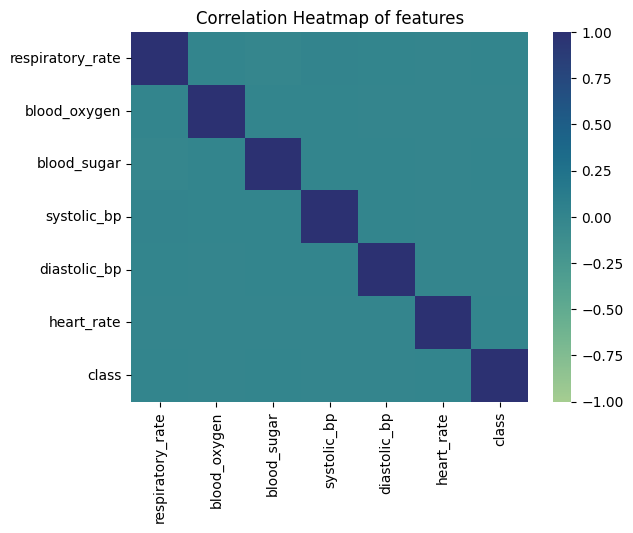

In [7]:
ax = sns.heatmap(
    data=df.corr(),
    cmap="crest",
    vmin=-1,
    
)
ax.set_title("Correlation Heatmap of features")
ax.set_xlabel(ax.get_xlabel(), rotation=15)

<Axes: title={'center': 'Class distribution of dataset'}>

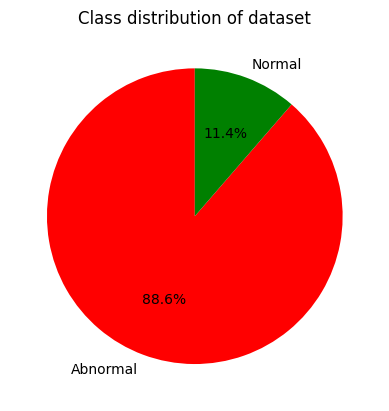

In [8]:
df['class'].value_counts().plot(kind='pie', startangle=90, autopct='%.1f%%', ylabel='', title='Class distribution of dataset', labels=['Abnormal', 'Normal'], colors=['red', 'green'])

The pie chart above shows a great disbalance in the class labels of the data - to fix this, we will use sampling to oversample the scarce class and undersample the abundant class to balance things out

In [9]:
from imblearn.combine import SMOTEENN
X = df.drop('class', axis=1)
y = df['class']

smote_enn = SMOTEENN(sampling_strategy='auto')
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
df = pd.concat([X_resampled, y_resampled], axis=1)

<Axes: title={'center': 'Updated class distribution of dataset'}>

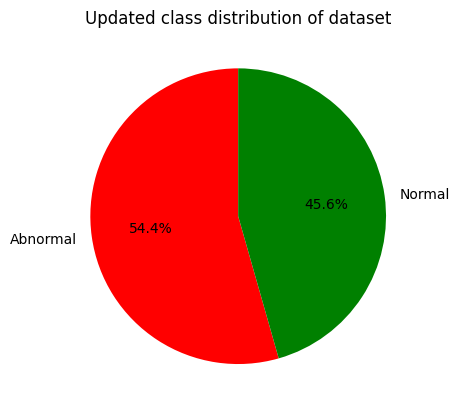

In [10]:
df['class'].value_counts().plot(kind='pie', startangle=90, autopct='%.1f%%', ylabel='', title='Updated class distribution of dataset', labels=['Abnormal', 'Normal'], colors=['red', 'green'])

Text(0.5, 0.98, 'Frequency Distribution of each feature')

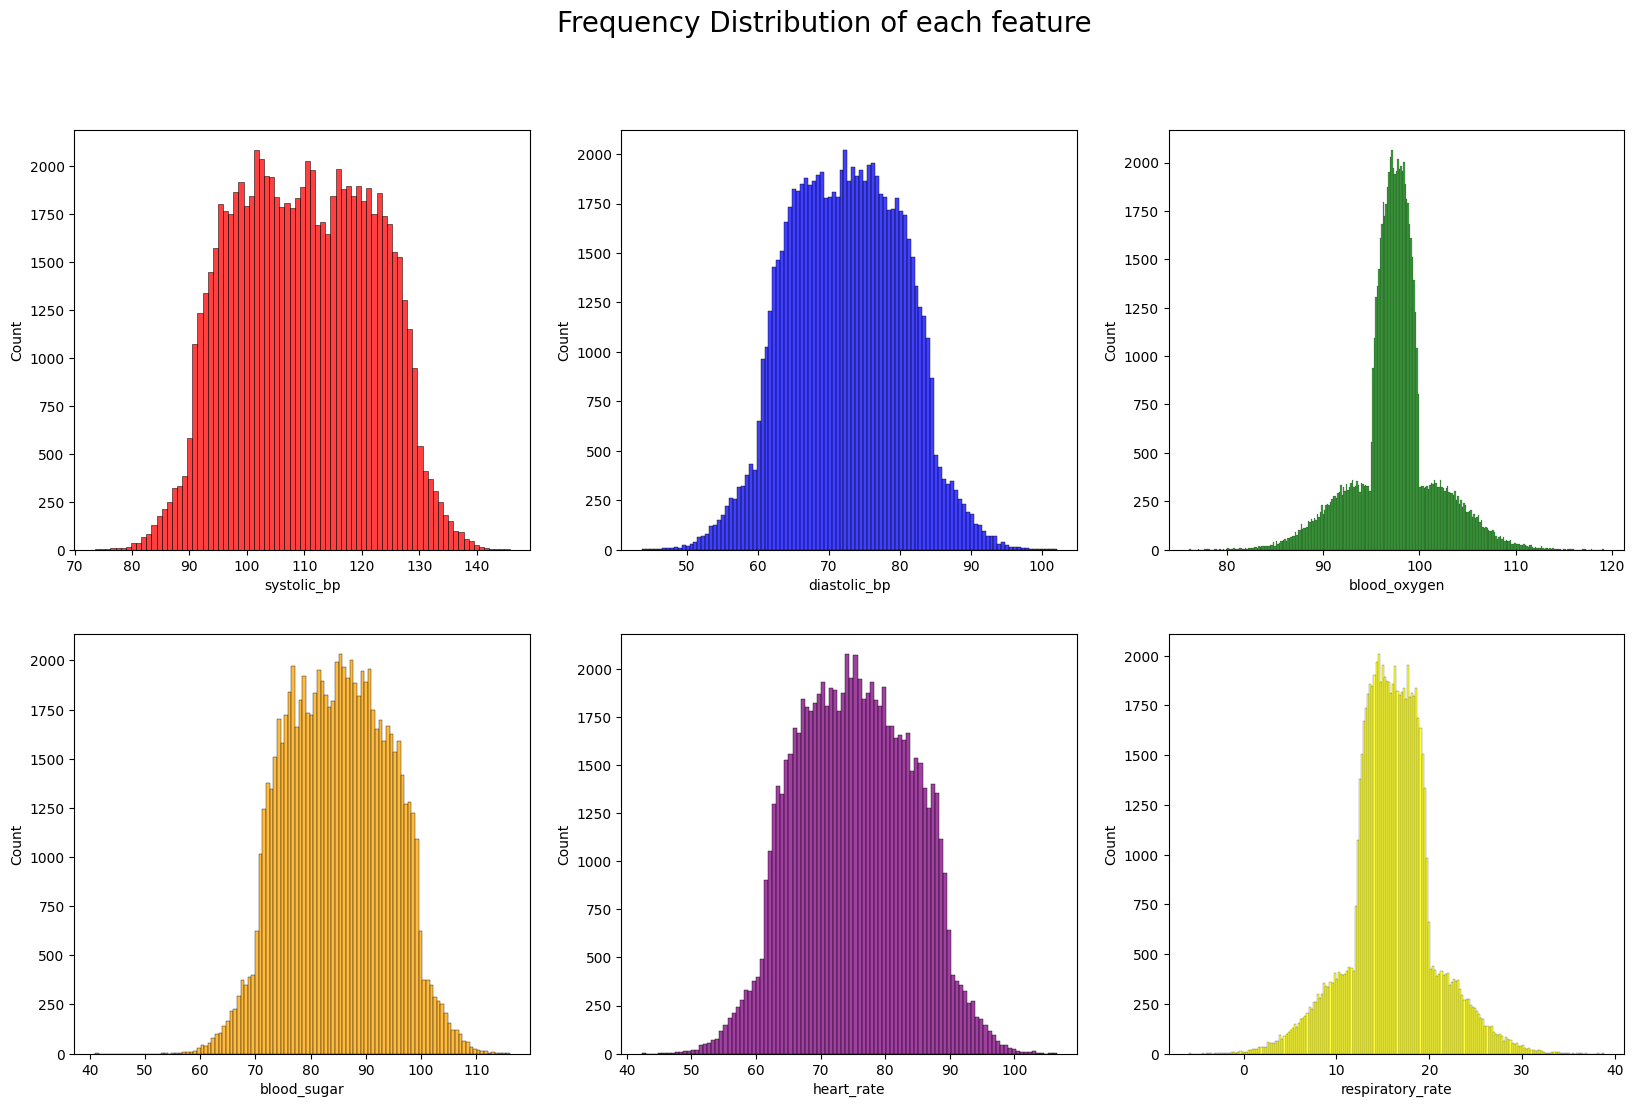

In [11]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
sns.histplot(data=df, x='systolic_bp', fill=True, ax=axes[0,0], color='red')
sns.histplot(data=df, x='diastolic_bp', fill=True, ax=axes[0,1], color='blue')
sns.histplot(data=df, x='blood_oxygen', fill=True,  ax=axes[0,2], color='green')
sns.histplot(data=df, x='blood_sugar', fill=True, ax=axes[1,0], color='orange')
sns.histplot(data=df, x='heart_rate', fill=True,  ax=axes[1,1], color='purple')
sns.histplot(data=df, x='respiratory_rate', fill=True, ax=axes[1,2], color='yellow')

plt.suptitle('Frequency Distribution of each feature', fontsize=20)

Text(0.5, 0.98, 'Kernal Density Estimate (KDE) Plots for each feature by class label')

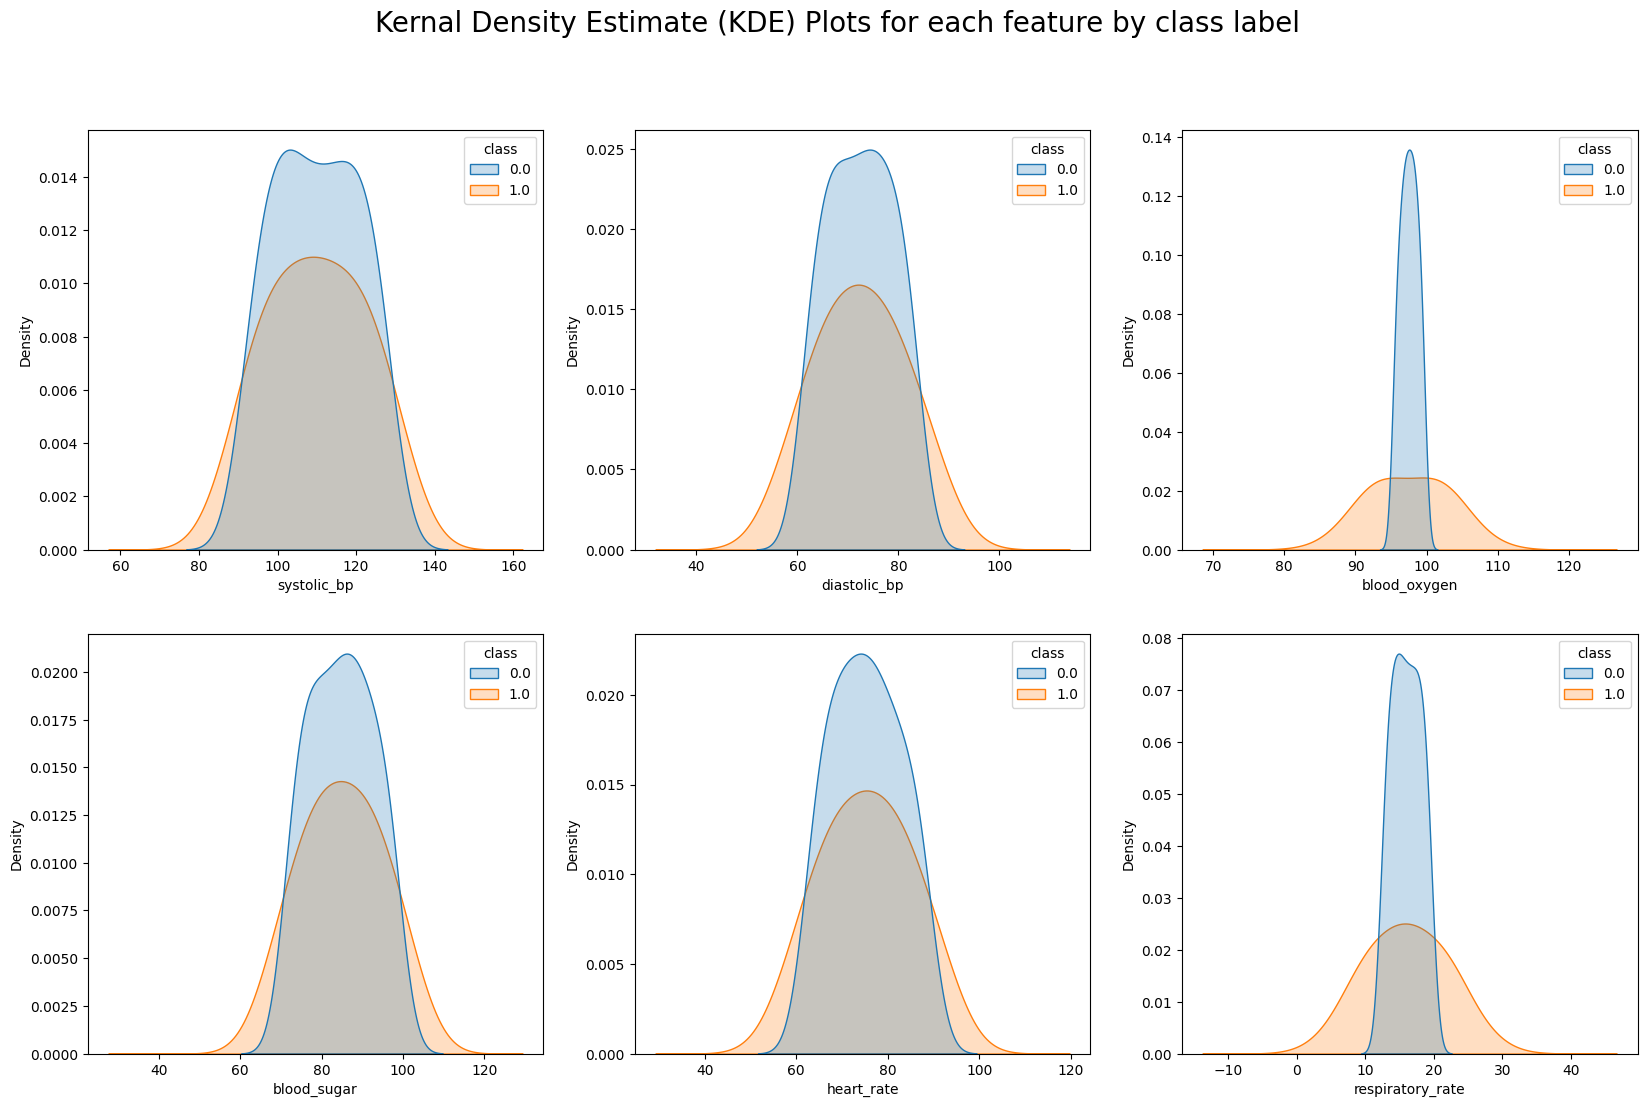

In [12]:
fig, axes = plt.subplots(2,3, figsize=(20, 12))
sns.kdeplot(data=df, x='systolic_bp', hue='class', fill=True, bw_adjust=3.5, ax=axes[0,0])
sns.kdeplot(data=df, x='diastolic_bp', hue='class', fill=True, bw_adjust=3.5, ax=axes[0,1])
sns.kdeplot(data=df, x='blood_oxygen', hue='class', fill=True, bw_adjust=3.5, ax=axes[0,2])
sns.kdeplot(data=df, x='blood_sugar', hue='class', fill=True, bw_adjust=3.5, ax=axes[1,0])
sns.kdeplot(data=df, x='heart_rate', hue='class', fill=True, bw_adjust=3.5, ax=axes[1,1])
sns.kdeplot(data=df, x='respiratory_rate', hue='class', fill=True, bw_adjust=3.5, ax=axes[1,2])

plt.suptitle('Kernal Density Estimate (KDE) Plots for each feature by class label', fontsize=20)

## Data Modeling

Feature preparation and test-train split of 60%/40%

In [13]:
X = df.drop(['class'], axis=1)
y = df['class']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Function to run and evaluate each model - Evaluation is done on the basis of:
* Average Accuracy over a Ten-Fold Cross Validation
* Precision Score
* Recall Score
* F1 Score

In [14]:
param_grid = {
    'Decision Tree Classifier': {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors Classifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'Hist Gradient Boosting Classifier': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_leaf': [1, 2, 4],  
        'l2_regularization': [0.0, 0.1, 0.2] 
    }
}


In [15]:
def evaluate_models(models):
    results_df = pd.DataFrame(
        columns=['Best Parameters', 'Average Accuracy (10 Folds Cross-Val)', 'Precision', 'Recall', 'F1 Score'])

    for model, model_name in models:
        print(f'Training {model_name}...')
        model.fit(x_train, y_train)
        
        best_params = model.best_params_
        best_model = model.best_estimator_
        
        y_pred = best_model.predict(x_test)
        
        metrics = {
            'Best Parameters': best_params,
            'Average Accuracy (10 Folds Cross-Val)': model.best_score_,
            'Precision': precision_score(y_pred, y_test, average='macro'),
            'Recall': recall_score(y_pred, y_test, average='macro'),
            'F1 Score': f1_score(y_pred, y_test, average='macro')
        }
        
        results_df.loc[model_name] = metrics

    return results_df

In [22]:
classification_models = [
    (
        GridSearchCV(
            HistGradientBoostingClassifier(),
            param_grid.get("Hist Gradient Boosting Classifier", {}),
            cv=10,
            n_jobs=-1,
        ),
        "Histogram Gradient Boosting Classifier",
    ),
    (
        GridSearchCV(
            DecisionTreeClassifier(),
            param_grid.get("Decision Tree Classifier", {}),
            cv=10,
            n_jobs=-1,
        ),
        "Decision Tree Classifier",
    ),
    (
        GridSearchCV(
            KNeighborsClassifier(),
            param_grid.get("K-Nearest Neighbors Classifier", {}),
            cv=10,
            n_jobs=-1,
        ),
        "K-Nearest Neighbors Classifier",
    ),
    (
        GridSearchCV(
            GaussianNB(),
            param_grid.get("", {}),
            cv=10,
            n_jobs=-1,
        ),
        "Guassian Naive Bayes",
    ),
]

model_results = evaluate_models(classification_models)

Training Histogram Gradient Boosting Classifier...
Training Decision Tree Classifier...
Training K-Nearest Neighbors Classifier...
Training Guassian Naive Bayes...


In [36]:
model_results = model_results.sort_values(by='Average Accuracy (10 Folds Cross-Val)', ascending=False)
model_results

,Best Parameters,Average Accuracy (10 Folds Cross-Val),Precision,Recall,F1 Score
Decision Tree Classifier,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.999651,0.999768,0.999735,0.999752
Histogram Gradient Boosting Classifier,"{'l2_regularization': 0.2, 'learning_rate': 0....",0.999466,0.999262,0.999372,0.999317
K-Nearest Neighbors Classifier,"{'n_neighbors': 3, 'weights': 'distance'}",0.974120,0.974481,0.979507,0.976446
Guassian Naive Bayes,{},0.966603,0.962730,0.969269,0.965134


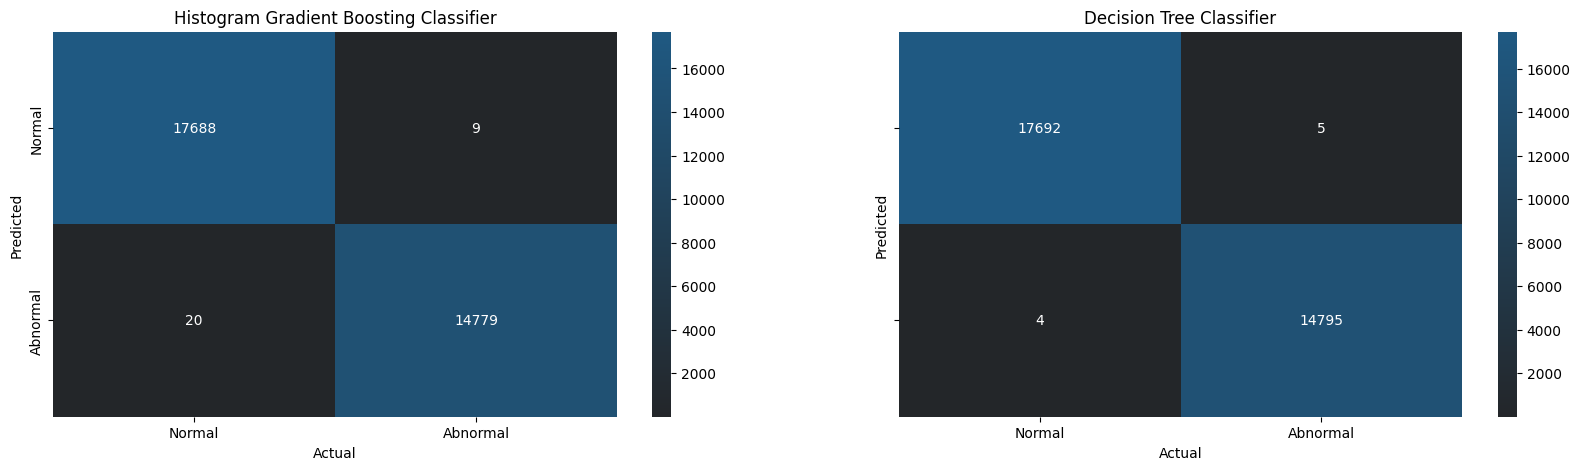

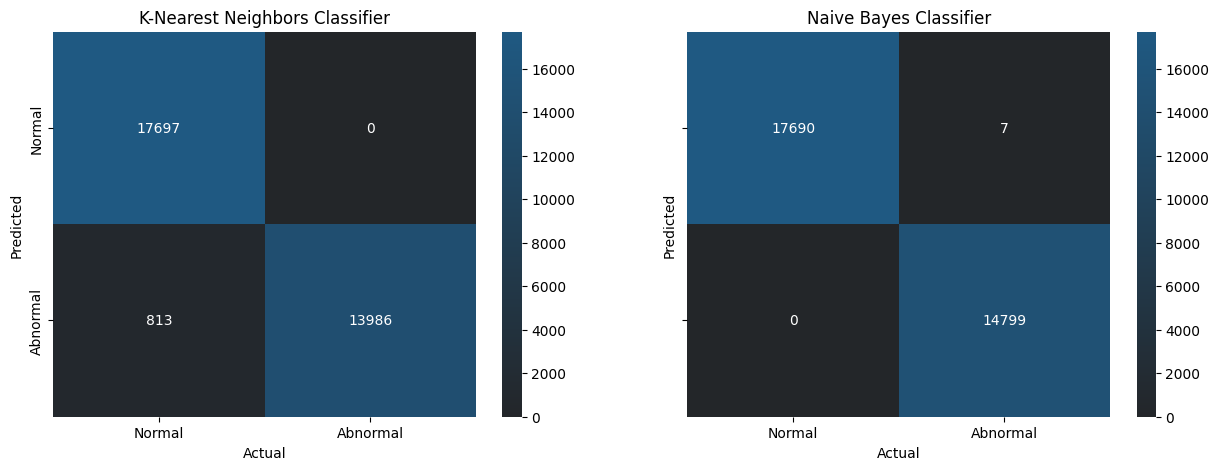

In [ ]:
predictions = [m.predict(x_test) for m in (model[0] for model in classification_models)]
class_names = ["Normal", "Abnormal"]
cms = [confusion_matrix(y_test, y_pred) for y_pred in predictions]
color_palette = cmap=sns.dark_palette("#1f5982", as_cmap=True)

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.heatmap(cms[0], cmap=color_palette, fmt="", ax=axes[0], xticklabels=class_names, yticklabels=class_names, annot=cms[0])
sns.heatmap(cms[1], cmap=color_palette, fmt="", ax=axes[1], xticklabels=class_names, yticklabels=class_names, annot=cms[1])

for i, ax in enumerate(axes):
    ax.set_title(classification_models[:3][i][1])
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Actual")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.heatmap(cms[2], cmap=color_palette, fmt="", ax=axes[0], xticklabels=class_names, yticklabels=class_names, annot=cms[2])
sns.heatmap(cms[3], cmap=color_palette, fmt="", ax=axes[1], xticklabels=class_names, yticklabels=class_names, annot=cms[3])

for i, ax in enumerate(axes):
    ax.set_title(classification_models[2:4][i][1])
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Actual")

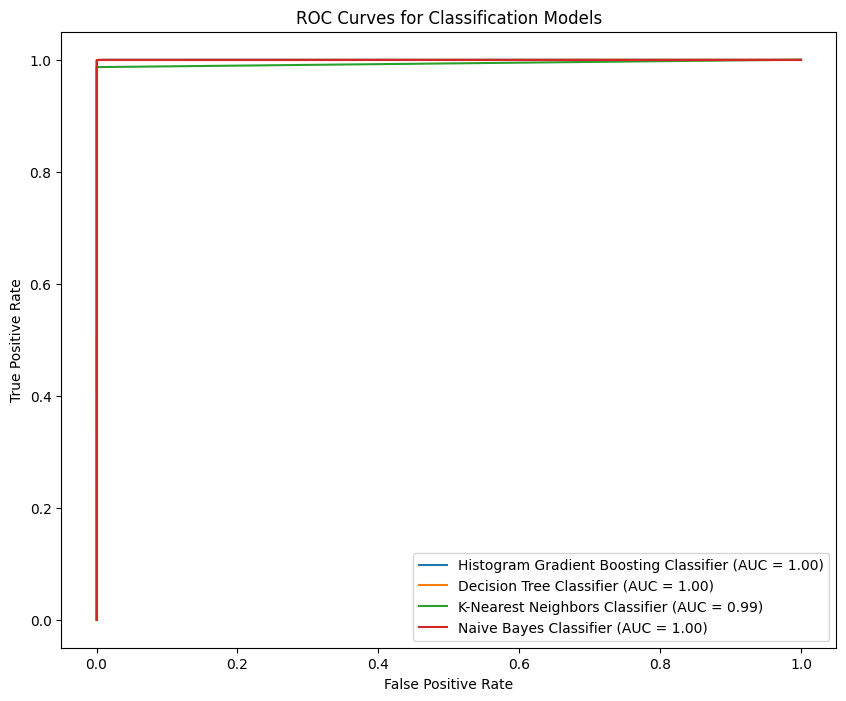

In [ ]:
roc_data = {}

# Loop through the models, fit them, and calculate ROC data
for model, model_name in classification_models:
    y_prob = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = (fpr, tpr, roc_auc)

# Create a plot for ROC curves of all models
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [31]:
import joblib

best_model_name = model_results.sort_values(by='Average Accuracy (10 Folds Cross-Val)', ascending=False).index[0]

best_model = next(model for model, name in classification_models if name == best_model_name)

joblib.dump(best_model, 'decision_tree_anomaly_detection.pkl')

['decision_tree_anomaly_detection.pkl']

In [50]:
X_new = np.array([55, 86, 8, 85, 44, 48])
feature_names = ["respiratory_rate", "blood_oxygen", "blood_sugar", "systolic_bp", "diastolic_bp", "heart_rate"]
X_new = pd.DataFrame([X_new], columns=feature_names)

# Make predictions using the Decision Tree Classifier
prediction = classification_models[1][0].predict(X_new)
print(prediction)

[1.]
